In [29]:
#### Programmer: Dylan Smith, 5/1/2020, email: smithdy6@msu.edu
#### This code implements a PDE solver in TensorFlow using a single hidden layer neural
#### network. The equation to be solved for is the 1D wave equation in x and t. 

Max absolute difference between analytical solution and TensorFlow DNN =  0.0006331486486939597
Time elapsed:  34.83663200000046  seconds


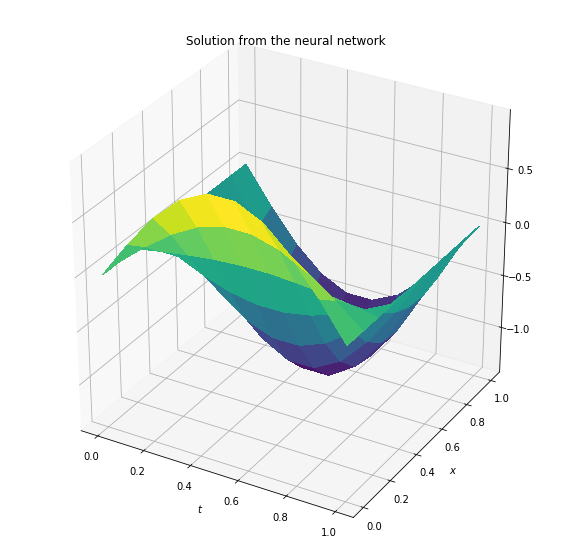

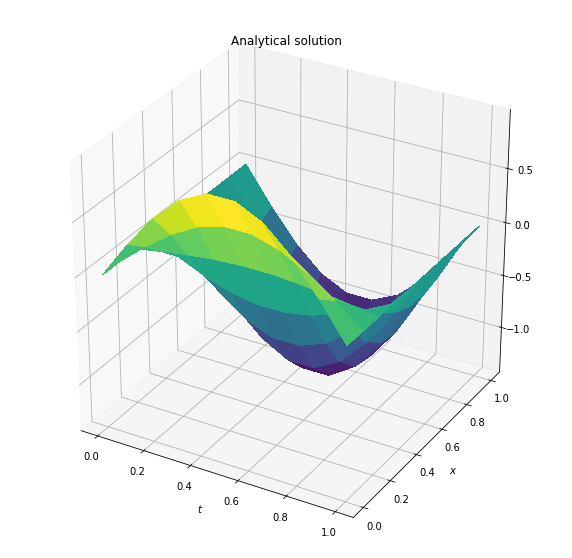

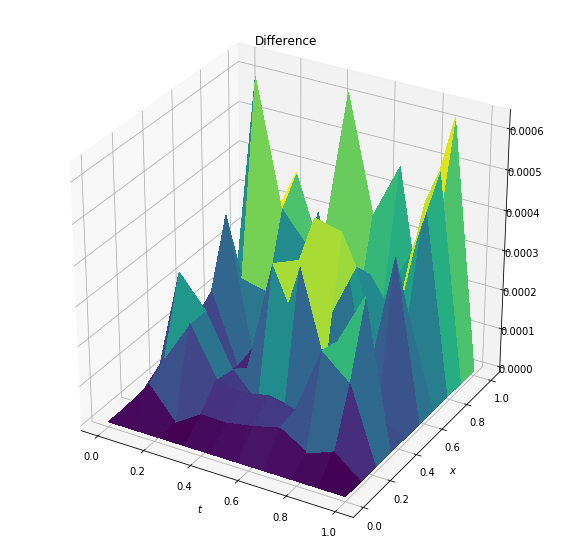

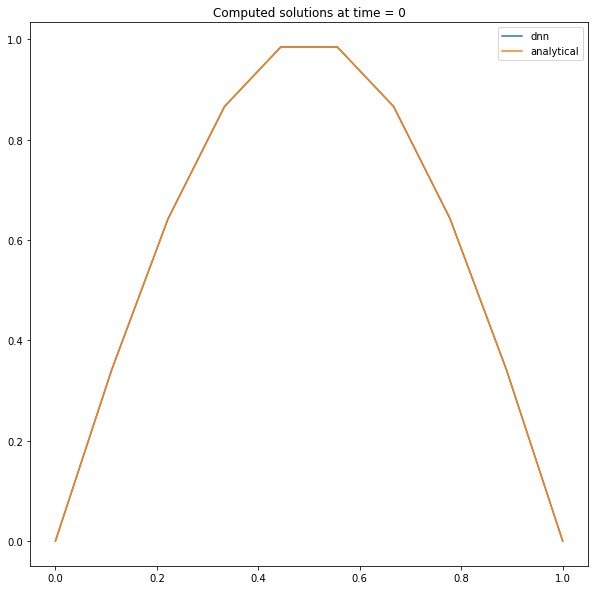

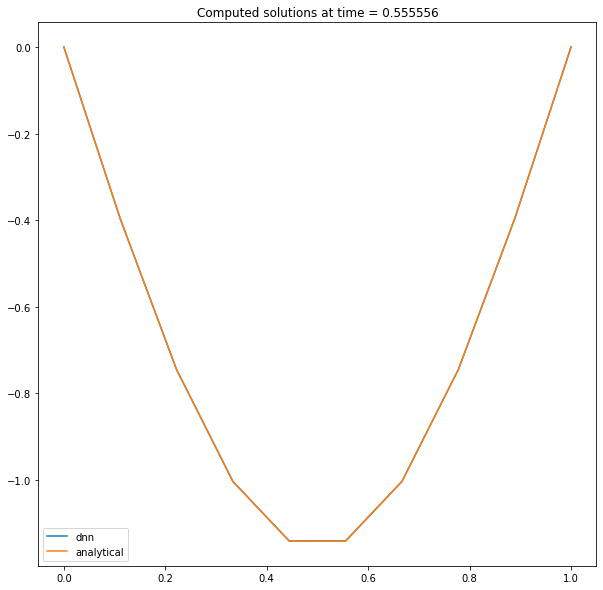

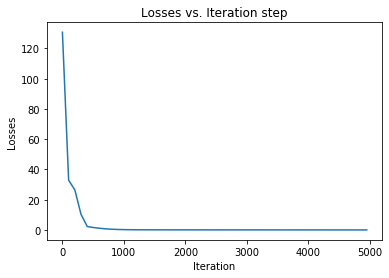

In [30]:
## Imports
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

## Import to revert to TensorFlow1 documentation; TensorFlow2's API was giving me trouble
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()

## Import to check computation time
import time
time_start = time.clock()

## Define 10-by-10 mesh in (x,t)
Nx = 10
x_np = np.linspace(0,1,Nx)

Nt = 10
t_np = np.linspace(0,1,Nt)

X,T = np.meshgrid(x_np, t_np)

x = X.ravel()
t = T.ravel()

## Constructing tensors for x and t to feed into TF NN

zeros = tf.reshape(tf.convert_to_tensor(np.zeros(x.shape)),shape=(-1,1))
x = tf.reshape(tf.convert_to_tensor(x),shape=(-1,1))
t = tf.reshape(tf.convert_to_tensor(t),shape=(-1,1))

points = tf.concat([x,t],1)

num_iter = 10000 # Training iterations
num_hidden_neurons = [90] #Number of neurons

X = tf.convert_to_tensor(X)
T = tf.convert_to_tensor(T)

## Define the neural network
with tf.variable_scope('dnn', reuse=tf.AUTO_REUSE):
    num_hidden_layers = np.size(num_hidden_neurons)

    previous_layer = points

    for l in range(num_hidden_layers):
        current_layer = tf.layers.dense(previous_layer, num_hidden_neurons[0],activation=tf.nn.sigmoid)
        previous_layer = current_layer

    dnn_output = tf.layers.dense(previous_layer, 1)

## Define the trial function
def u(x):
    return tf.sin(np.pi*x)

def v(x):
    return -np.pi*tf.sin(np.pi*x)

with tf.name_scope('loss'):
    u_trial = (1 - t**2)*u(x) + t*v(x) + x*(1-x)*t**2*dnn_output

    u_trial_d2t =  tf.gradients(tf.gradients(u_trial,t),t) #Compute second derivative of u in
    u_trial_d2x = tf.gradients(tf.gradients(u_trial,x),x)
    
    loss = tf.losses.mean_squared_error(zeros, u_trial_d2t[0] - u_trial_d2x[0])

## Optimizer to perform optimization     
learning_rate = 0.01
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    traning_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

## Define the analytic solution
u_analytic = tf.sin(np.pi*x)*tf.cos(np.pi*t) - tf.sin(np.pi*x)*tf.sin(np.pi*t)
u_dnn = None
losses = [] #list to store loss values at specified iteration steps

## The execution phase
with tf.Session() as sess:
    init.run()
    for i in range(num_iter):
        sess.run(traning_op)

        if i % 100 == 0:
            losses.append(loss.eval())

    u_analytic = u_analytic.eval()
    u_dnn = u_trial.eval()


## Compare with the analytical solution
diff = np.abs(u_analytic - u_dnn)
print('Max absolute difference between analytical solution and TensorFlow DNN = ',np.max(diff))

U_analytic = u_analytic.reshape((Nt,Nx))
U_dnn = u_dnn.reshape((Nt,Nx))

diff = np.abs(U_analytic - U_dnn)

time_elapsed = (time.clock() - time_start)
print ("Time elapsed: ", time_elapsed, " seconds")

## Plot the results

X,T = np.meshgrid(x_np, t_np)

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_title('Solution from the neural network')
s = ax.plot_surface(X,T,U_dnn,linewidth=0,antialiased=False,cmap=cm.viridis)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$');

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_title('Analytical solution')
s = ax.plot_surface(X,T,U_analytic,linewidth=0,antialiased=False,cmap=cm.viridis)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$');

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_title('Difference')
s = ax.plot_surface(X,T,diff,linewidth=0,antialiased=False,cmap=cm.viridis)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$');

## Take some 3D slices

indx1 = 0
indx2 = int(Nt/2)

t1 = t_np[indx1]
t2 = t_np[indx2]

## Slice the results from the DNN
res1 = U_dnn[indx1,:]
res2 = U_dnn[indx2,:]

# Slice the analytical results
res_analytical1 = U_analytic[indx1,:]
res_analytical2 = U_analytic[indx2,:]

## Plot the slices
plt.figure(figsize=(10,10))
plt.title("Computed solutions at time = %g"%t1)
plt.plot(x_np, res1)
plt.plot(x_np,res_analytical1)
plt.legend(['dnn','analytical'])

plt.figure(figsize=(10,10))
plt.title("Computed solutions at time = %g"%t2)
plt.plot(x_np, res2)
plt.plot(x_np,res_analytical2)
plt.legend(['dnn','analytical'])
plt.show()

## Plot Loss vs. Iteration 
iter_list=np.linspace(0,num_iter,len(losses))
plt.plot(iter_list[:50], losses[:50])
plt.xlabel("Iteration")
plt.ylabel("Losses")
plt.title("Losses vs. Iteration step")

plt.show()

In [31]:
#### This cell converts the above NN Solver into a function in which the 
#### number of iterations and the number of hidden neurons as inputs

## Imports
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import time

## Import to revert to TensorFlow1 documentation; TensorFlow2's API was giving me trouble
import tensorflow.compat.v1 as tf

def nn_solver(num_iter, num_hidden_neurons):
## Import to check computation time
    tf.disable_v2_behavior()
    tf.reset_default_graph()

    time_start = time.clock()

## Define 10-by-10 mesh in (x,t)
    Nx = 10
    x_np = np.linspace(0,1,Nx)

    Nt = 10
    t_np = np.linspace(0,1,Nt)

    X,T = np.meshgrid(x_np, t_np)

    x = X.ravel()
    t = T.ravel()

## Constructing tensors for x and t to feed into TF NN

    zeros = tf.reshape(tf.convert_to_tensor(np.zeros(x.shape)),shape=(-1,1))
    x = tf.reshape(tf.convert_to_tensor(x),shape=(-1,1))
    t = tf.reshape(tf.convert_to_tensor(t),shape=(-1,1))

    points = tf.concat([x,t],1)

    num_iter = num_iter # Training iterations
    num_hidden_neurons = [num_hidden_neurons] #Number of neurons

    X = tf.convert_to_tensor(X)
    T = tf.convert_to_tensor(T)

## Define the neural network
    with tf.variable_scope('dnn', reuse=tf.AUTO_REUSE):
        num_hidden_layers = np.size(num_hidden_neurons)

        previous_layer = points

        for l in range(num_hidden_layers):
            current_layer = tf.layers.dense(previous_layer, num_hidden_neurons[0],activation=tf.nn.sigmoid)
            previous_layer = current_layer

        dnn_output = tf.layers.dense(previous_layer, 1)

## Define the trial function
    def u(x):
        return tf.sin(np.pi*x)

    def v(x):
        return -np.pi*tf.sin(np.pi*x)

    with tf.name_scope('loss'):
        u_trial = (1 - t**2)*u(x) + t*v(x) + x*(1-x)*t**2*dnn_output

        u_trial_d2t =  tf.gradients(tf.gradients(u_trial,t),t)
        u_trial_d2x = tf.gradients(tf.gradients(u_trial,x),x)

        loss = tf.losses.mean_squared_error(zeros, u_trial_d2t[0] - u_trial_d2x[0])

## Optimizer to perform optimization     
    learning_rate = 0.01
    with tf.name_scope('train'):
        optimizer = tf.train.AdamOptimizer(learning_rate)
        traning_op = optimizer.minimize(loss)

    init = tf.global_variables_initializer()

## Define the analytic solution
    u_analytic = tf.sin(np.pi*x)*tf.cos(np.pi*t) - tf.sin(np.pi*x)*tf.sin(np.pi*t)
    u_dnn = None
    losses = [] #list to store loss values at specified iteration steps

## The execution phase
    with tf.Session() as sess:
        init.run()
        for i in range(num_iter):
            sess.run(traning_op)

            if i % 100 == 0:
                losses.append(loss.eval())

        u_analytic = u_analytic.eval()
        u_dnn = u_trial.eval()


## Compare with the analytical solution
    diff = np.abs(u_analytic - u_dnn)
    #print('Max absolute difference between analytical solution and TensorFlow DNN = ',np.max(diff))

    U_analytic = u_analytic.reshape((Nt,Nx))
    U_dnn = u_dnn.reshape((Nt,Nx))

    diff = np.abs(U_analytic - U_dnn)

    time_elapsed = (time.clock() - time_start)
    #print ("Time elapsed: ", time_elapsed, " seconds")

    return np.max(diff)

In [32]:
## Defining arrays to store different iterations and hidden neuron sizes
num_iter_list = np.arange(10, 2000, 100)

## Defining empty lists to store error values
errors_iter = [] 

for i in num_iter_list:
    errors_iter.append(nn_solver(i, 90))
for i in num_neuron_list:
    errors_neurons.append(nn_solver(2000, i))

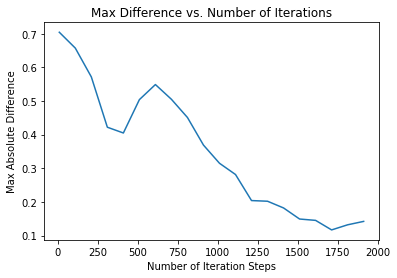

In [33]:
## Plot the results

plt.plot(num_iter_list, rel_errors_iter)
plt.title("Max Difference vs. Number of Iterations")
plt.xlabel("Number of Iteration Steps")
plt.ylabel("Max Absolute Difference")
plt.show()

In [34]:
## Plot results

num_neuron_list = np.arange(2,90,5)
errors_neurons = []

for i in num_neuron_list:
    errors_neurons.append(nn_solver(2000, i))

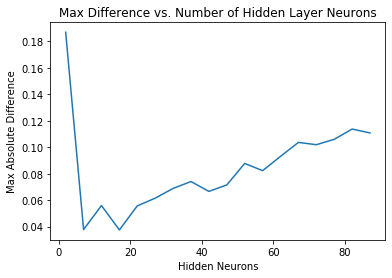

In [35]:
plt.plot(num_neuron_list, rel_errors_neurons)
plt.title("Max Difference vs. Number of Hidden Layer Neurons")
plt.xlabel("Hidden Neurons")
plt.ylabel("Max Absolute Difference")
plt.show()